In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [3]:
import re
from pathlib import Path
from typing import Final, TypeAlias

import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import gutenberg
from pandas import DataFrame
from shap import Explainer

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer
from authorship_tool.util.ml import trainer as trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import GutenbergKFoldPaths, GutenbergPaths

Project root: /workspaces/shap-authorship-analysis-demo
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPastParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/participle/adjectivesPresentParticiple.csv
Path: data/john_blake_2023/wordLists/adjectives/limit/limit_adjectives.csv
Path: data/john_blake_2023/wordLists/adjectives/extraposition/adjectives_extraposition.csv
Path: data/liyanage_vijini_2022/Dataset/FullyGenerated
Path: data/liyanage_vijini_2022/Dataset/Hybrid_AbstractDataset
Path: data/uoa-thesis-2014-2017
Path: out/text_data
Path: out/processed_text
Path: out/dataset
Path: out/lgbm/model
Path: out/shap/figure


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [5]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")


#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [6]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")


1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [7]:
AUTHOR_A: Final[str] = "austen"
AUTHOR_B: Final[str] = "chesterton"
PARAGRAPH_INIT_INDEX: Final[int] = 10
PARAGRAPH_NUM: Final[int] = PARAGRAPH_INIT_INDEX + 4000

In [8]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras][PARAGRAPH_INIT_INDEX:PARAGRAPH_NUM]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")


The evil of the actual disparity in their ages ( and Mr . Woodhouse had not married early ) was much increased by his constitution and habits ; for having been a valetudinarian all his life , without activity of mind or body , he was a much older man in ways than in years ; and though everywhere beloved for the friendliness of his heart and his amiable temper , his talents could not have recommended him at any time .
Her sister , though comparatively but little removed by matrimony , being settled in London , only sixteen miles off , was much beyond her daily reach ; and many a long October and November evening must be struggled through at Hartfield , before Christmas brought the next visit from Isabella and her husband , and their little children , to fill the house , and give her pleasant society again .
Highbury , the large and populous village , almost amounting to a town , to which Hartfield , in spite of its separate lawn , and shrubberies , and name , did really belong , afforde

In [9]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras][PARAGRAPH_INIT_INDEX:PARAGRAPH_NUM]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")


" Well , the fact is ," said the other , " that much as I admire your rhetoric and the rhetoric of your school , from a purely verbal point of view , such little study of you and your school in human history as I have been enabled to make has led me to -- er -- rather singular conclusion , which I find great difficulty in expressing , especially in a foreign language ."
" Come , come ," said the Professor , encouragingly , " I ' ll help you out . How did my view strike you ?"
" Well , the truth is , I know I don ' t express it properly , but somehow it seemed to me that you always convey ideas of that kind with most eloquence , when -- er -- when ----"
" Oh ! get on ," cried Lucifer , boisterously .
" Well , in point of fact when your flying ship is just going to run into something . I thought you wouldn ' t mind my mentioning it , but it ' s running into something now ."
Lucifer exploded with an oath and leapt erect , leaning hard upon the handle that acted as a helm to the vessel . F

In [10]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")


total: 8000 paragraphs (samples)


In [11]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)


['$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [12]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)


In [13]:
para_ans_pairs: list[tuple[Para2dStr, bool]] = [(para, True) for para in paras_a] + [
    (para, False) for para in paras_b
]


In [14]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]


In [15]:
datasets: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T


In [16]:
datasets.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    datasets.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    datasets[col] = datasets[col].astype(dtype)


In [17]:
df = datasets.iloc[:, :-1]
display(df.head(10))


,$,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,``
0,0.0,0.0,0.012195,0.012195,0.036585,0.024390,0.024390,0.060976,0.000000,0.073171,0.0,0.0,0.158537,0.048780,0.012195,0.0,0.000000,0.000000,0.0,0.0,0.012195,0.146341,0.024390,0.000000,0.060976,0.012195,0.000000,0.024390,0.073171,0.060976,0.0,0.0,0.000000,0.0,0.000000,0.0,0.012195,0.036585,0.012195,0.060976,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.111111,0.013889,0.013889,0.083333,0.000000,0.041667,0.0,0.0,0.111111,0.125000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.013889,0.111111,0.083333,0.000000,0.027778,0.000000,0.000000,0.000000,0.069444,0.055556,0.0,0.0,0.000000,0.0,0.013889,0.0,0.041667,0.027778,0.013889,0.041667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.080247,0.024691,0.018519,0.052469,0.003086,0.052469,0.0,0.0,0.123457,0.052469,0.000000,0.0,0.006173,0.000000,0.0,0.0,0.018519,0.126543,0.037037,0.003086,0.021605,0.006173,0.003086,0.067901,0.024691,0.074074,0.0,0.0,0.003086,0.0,0.037037,0.0,0.033951,0.074074,0.012346,0.030864,0.000000,0.000000,0.003086,0.003086,0.0,0.006173,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.038462,0.0,0.0,0.076923,0.038462,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.115385,0.192308,0.000000,0.000000,0.000000,0.000000,0.153846,0.000000,0.115385,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.076923,0.000000,0.000000,0.038462,0.038462,0.000000,0.038462,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.088235,0.029412,0.029412,0.029412,0.000000,0.058824,0.0,0.0,0.088235,0.117647,0.000000,0.0,0.000000,0.014706,0.0,0.0,0.029412,0.073529,0.058824,0.000000,0.014706,0.000000,0.000000,0.117647,0.029412,0.029412,0.0,0.0,0.000000,0.0,0.000000,0.0,0.029412,0.000000,0.000000,0.029412,0.073529,0.044118,0.000000,0.000000,0.0,0.014706,0.0
5,0.0,0.0,0.000000,0.000000,0.027027,0.027027,0.000000,0.054054,0.027027,0.108108,0.0,0.0,0.108108,0.162162,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.162162,0.027027,0.000000,0.027027,0.000000,0.000000,0.027027,0.081081,0.027027,0.0,0.0,0.000000,0.0,0.000000,0.0,0.027027,0.000000,0.000000,0.000000,0.027027,0.054054,0.000000,0.000000,0.0,0.027027,0.0
6,0.0,0.0,0.000000,0.000000,0.026316,0.026316,0.026316,0.052632,0.000000,0.000000,0.0,0.0,0.000000,0.026316,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.105263,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.157895,0.000000,0.105263,0.0,0.0,0.000000,0.0,0.052632,0.0,0.236842,0.000000,0.105263,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.026316,0.0
7,0.0,0.0,0.000000,0.000000,0.038462,0.076923,0.000000,0.000000,0.000000,0.038462,0.0,0.0,0.000000,0.076923,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.038462,0.115385,0.038462,0.000000,0.000000,0.000000,0.000000,0.076923,0.038462,0.192308,0.0,0.0,0.000000,0.0,0.038462,0.0,0.115385,0.000000,0.000000,0.000000,0.038462,0.038462,0.000000,0.000000,0.0,0.038462,0.0
8,0.0,0.0,0.000000,0.000000,0.136364,0.045455,0.000000,0.000000,0.000000,0.045455,0.0,0.0,0.090909,0.045455,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.045455,0.318182,0.045455,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.0,0.0,0.000000,0.0,0.045455,0.0,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
9,0.0,0.0,0.000000,0.000000,0.000000,0.028571,0.000000,0.057143,0.000000,0.114286,0.0,0.0,0.085714,0.085714,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.028571,0.114286,0.028571,0.000000,0.057143,0.028571,0.000000,0.028571,0.028571,0.028571,0.0,0.0,0.000000,0.0,0.085714,0.0,0.085714,0.000000,0.028571,0.000000,0.057143,0.000000,0.000000,0.000000,0.0,0.028571,0.0


In [18]:
nd_category = np.array(datasets.iloc[:, -1], dtype=bool)
display(nd_category[:5])


array([ True,  True,  True,  True,  True])

In [19]:
print(df.shape)


(8000, 47)


In [20]:
print(df.dtypes)


$           float64
''          float64
(           float64
)           float64
,           float64
.           float64
:           float64
CC          float64
CD          float64
DT          float64
EX          float64
FW          float64
IN          float64
JJ          float64
JJR         float64
JJS         float64
JJ_exp      float64
JJ_lim      float64
JJ_pp       float64
JJ_presp    float64
MD          float64
NN          float64
NNP         float64
NNPS        float64
NNS         float64
PDT         float64
POS         float64
PRP         float64
PRP$        float64
RB          float64
RBR         float64
RBS         float64
RP          float64
SYM         float64
TO          float64
UH          float64
VB          float64
VBD         float64
VBG         float64
VBN         float64
VBP         float64
VBZ         float64
WDT         float64
WP          float64
WP$         float64
WRB         float64
``          float64
dtype: object


In [21]:
print(df.isna().sum())


$           0
''          0
(           0
)           0
,           0
.           0
:           0
CC          0
CD          0
DT          0
EX          0
FW          0
IN          0
JJ          0
JJR         0
JJS         0
JJ_exp      0
JJ_lim      0
JJ_pp       0
JJ_presp    0
MD          0
NN          0
NNP         0
NNPS        0
NNS         0
PDT         0
POS         0
PRP         0
PRP$        0
RB          0
RBR         0
RBS         0
RP          0
SYM         0
TO          0
UH          0
VB          0
VBD         0
VBG         0
VBN         0
VBP         0
VBZ         0
WDT         0
WP          0
WP$         0
WRB         0
``          0
dtype: int64


In [22]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)
result: TrainingResult = trainer.train_once(source)


[LightGBM] [Info] Number of positive: 3190, number of negative: 3210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8983
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498437 -> initscore=-0.006250
[LightGBM] [Info] Start training from score -0.006250


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
score: Score | None = result.score


In [ ]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")


auc-roc score: 0.5706516643225504
f1 score: 0.39692044482463645
accuracy score: 0.559375


In [ ]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))


predicted,False,True
actual,,
False,663,127
True,578,232


In [ ]:
dump(result, GutenbergPaths)


In [ ]:
test_data: DataFrame = result.splitted_dataset.test_data
explainer: Explainer = result.shap_data.explainer
shap_expected_val: np.float64 = result.shap_data.shap_expected_val
shap_vals = result.shap_data.shap_vals

FIRST_DATA_INDEX: Final[int] = 0


In [ ]:
shap.initjs()


In [ ]:
SHAP_GUTENBERG_FIGURE_DIR: Path = GutenbergPaths.shap_figure_dir


<Figure size 640x480 with 0 Axes>

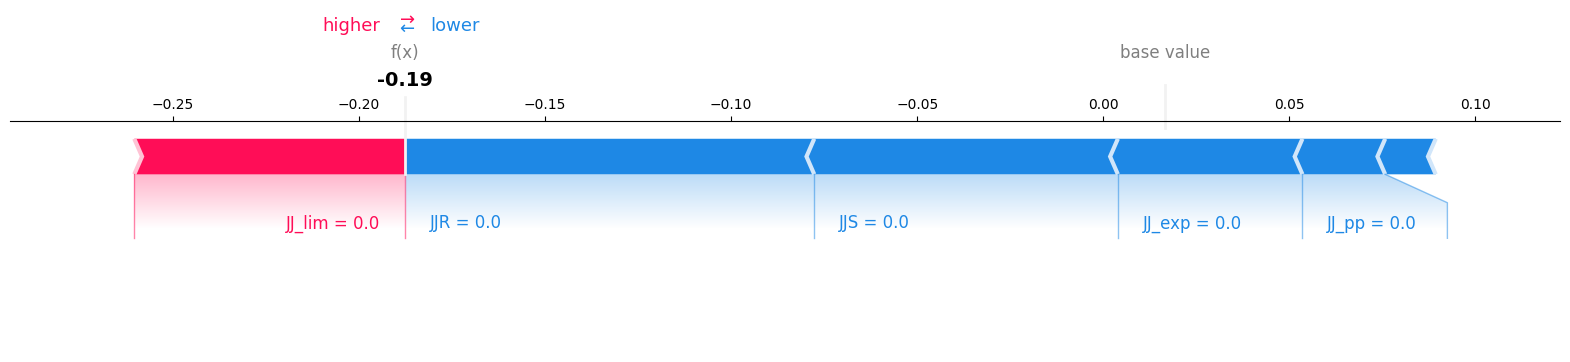

In [ ]:
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
)
shap.force_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


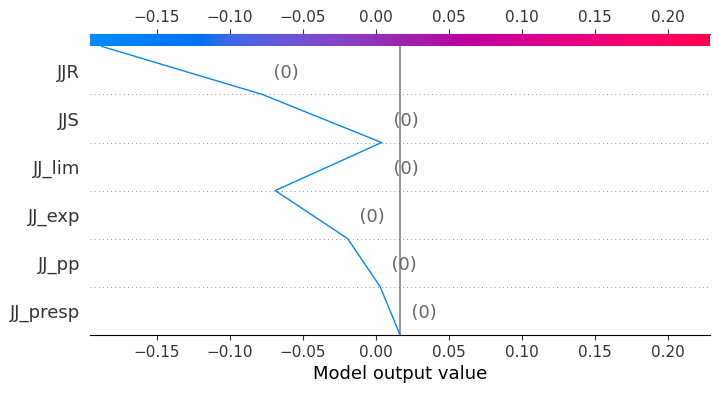

In [ ]:
shap.decision_plot(
    shap_expected_val,
    shap_vals[FIRST_DATA_INDEX],
    test_data.iloc[FIRST_DATA_INDEX],
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


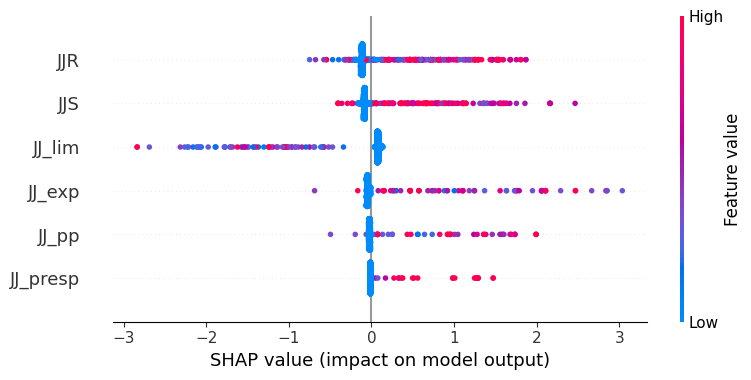

In [ ]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


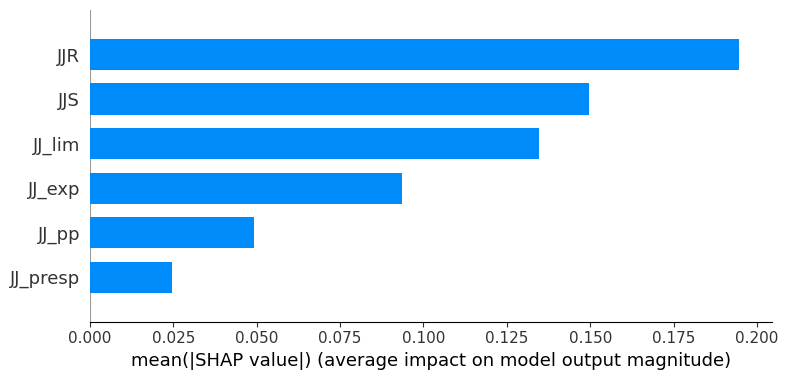

In [ ]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()


In [ ]:

results_for_each_iters: list[TrainingResult] = cv_trainer.train_kfold(source, 100)


[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[LightGBM] [Info] Start training from score -0.002525
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[LightGBM] [Info] Start training from score -0.002525
[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000505
[LightGBM] [I

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500379 -> initscore=0.001515
[LightGBM] [Info] Start training from score 0.001515
[LightGBM] [Info] Number of positive: 3954, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3956, number of negative: 3964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499495 -> initscore=-0.002020
[LightGBM] [Info] Start training from score -0.002020
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001515
[LightGBM] [Info] Start training from score -0.001515
[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3965, number of negative: 3955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500631 -> initscore=0.002525
[LightGBM] [Info] Start training from score 0.002525
[LightGBM] [Info] Number of positive: 3959, number of negative: 3961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499874 -> initscore=-0.000505
[LightGBM] [In

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[LightGBM] [Info] Start training from score -0.002525
[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000505
[LightGBM] [I

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3965, number of negative: 3955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500631 -> initscore=0.002525
[Lig

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500253 -> initscore=0.001010
[LightGBM] [Info] Start training from score 0.001010
[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500379 -> initscore=0.001515
[LightGBM] [Info] Start training from score 0.001515
[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3964, number of negative: 3956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500505 -> initscore=0.002020
[LightGBM] [Info] Start training from score 0.002020
[LightGBM] [Info] Number of positive: 3965, number of negative: 3955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500253 -> initscore=0.001010
[LightGBM] [Info] Start training from score 0.001010
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001515
[LightGBM] [Info] Start training from score -0.001515
[LightGBM] [Info] Number of positive: 3966, number of negative: 3954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3954, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499242 -> initscore=-0.003030
[LightGBM] [Info] Start training from score -0.003030
[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3964, number of negative: 3956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500505 -> initscore=0.002020
[LightGBM] [Info] Start training from score 0.002020
[LightGBM] [Info] Number of positive: 3966, number of negative: 3954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500758 -> initscore=0.003030
[LightGBM] [Info] Start training from score 0.003030


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3956, number of negative: 3964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499495 -> initscore=-0.002020
[LightGBM] [Info] Start training from score -0.002020
[LightGBM] [Info] Number of positive: 3969, number of negative: 3951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501136 -> initscore=0.004545
[LightGBM] [I

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[LightGBM] [Info] Start training from score -0.002525
[LightGBM] [Info] Number of positive: 3964, number of negative: 3956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500505 -> initscore=0.002020
[LightGBM] [I

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3954, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499242 -> initscore=-0.003030
[LightGBM] [Info] Start training from score -0.003030
[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000505
[LightGBM] [I

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500253 -> initscore=0.001010
[LightGBM] [Info] Start training from score 0.001010
[LightGBM] [Info] Number of positive: 3958, number of negative: 3962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[LightGBM] [Info] Start training from score -0.002525


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3958, number of negative: 3962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499747 -> initscore=-0.001010
[LightGBM] [Info] Start training from score -0.001010
[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001515
[LightGBM] [Info] Start training from score -0.001515
[LightGBM] [Info] Number of positive: 3969, number of negative: 3951
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500379 -> initscore=0.001515
[LightGBM] [Info] Start training from score 0.001515
[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3965, number of negative: 3955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500631 -> initscore=0.002525
[LightGBM] [Info] Start training from score 0.002525
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000505
[LightGBM] [Info] Start training from score 0.000505
[LightGBM] [Info] Number of positive: 3958, number of negative: 3962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[Li

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000505
[LightGBM] [Info] Start training from score 0.000505
[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500253 -> initscore=0.001010
[LightGBM] [Info] Start training from score 0.001010


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500253 -> initscore=0.001010
[LightGBM] [Info] Start training from score 0.001010
[LightGBM] [Info] Number of positive: 3953, number of negative: 3967
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3965, number of negative: 3955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500631 -> initscore=0.002525
[LightGBM] [Info] Start training from score 0.002525
[LightGBM] [Info] Number of positive: 3953, number of negative: 3967
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001515
[LightGBM] [Info] Start training from score -0.001515


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3954, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499242 -> initscore=-0.003030
[LightGBM] [Info] Start training from score -0.003030
[LightGBM] [Info] Number of positive: 3959, number of negative: 3961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499874 -> initscore=-0.000505
[LightGBM] [

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3970, number of negative: 3950
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501263 -> initscore=0.005051
[LightGBM] [Info] Start training from score 0.005051
[LightGBM] [Info] Number of positive: 3959, number of negative: 3961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499874 -> initscore=-0.000505
[LightGBM] [In

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3964, number of negative: 3956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500505 -> initscore=0.002020
[LightGBM] [Info] Start training from score 0.002020
[LightGBM] [Info] Number of positive: 3959, number of negative: 3961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3959, number of negative: 3961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 859
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499874 -> initscore=-0.000505
[LightGBM] [Info] Start training from score -0.000505
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499369 -> initscore=-0.002525
[LightGBM] [Info] Start training from score -0.002525
[LightGBM] [Info] Number of positive: 3955, number of negative: 3965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001515
[LightGBM] [Info] Start training from score -0.001515
[LightGBM] [Info] Number of positive: 3967, number of negative: 3953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500884 -> initscore=0.003535
[LightGBM] [I

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3962, number of negative: 3958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500253 -> initscore=0.001010
[LightGBM] [Info] Start training from score 0.001010
[LightGBM] [Info] Number of positive: 3966, number of negative: 3954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3957, number of negative: 3963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499621 -> initscore=-0.001515
[LightGBM] [Info] Start training from score -0.001515
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500379 -> initscore=0.001515
[Lig

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3965, number of negative: 3955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500631 -> initscore=0.002525
[LightGBM] [Info] Start training from score 0.002525
[LightGBM] [Info] Number of positive: 3951, number of negative: 3969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3967, number of negative: 3953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500884 -> initscore=0.003535
[LightGBM] [Info] Start training from score 0.003535
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3958, number of negative: 3962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499747 -> initscore=-0.001010
[LightGBM] [Info] Start training from score -0.001010
[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3961, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500126 -> initscore=0.000505
[Lig

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3953, number of negative: 3967
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499116 -> initscore=-0.003535
[LightGBM] [Info] Start training from score -0.003535
[LightGBM] [Info] Number of positive: 3956, number of negative: 3964
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500379 -> initscore=0.001515
[Lig

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3959, number of negative: 3961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499874 -> initscore=-0.000505
[LightGBM] [Info] Start training from score -0.000505
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Bo

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3963, number of negative: 3957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500379 -> initscore=0.001515
[LightGBM] [Info] Start training from score 0.001515
[LightGBM] [Info] Number of positive: 3960, number of negative: 3960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 3964, number of negative: 3956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500505 -> initscore=0.002020
[LightGBM] [Info] Start training from score 0.002020
[LightGBM] [Info] Number of positive: 3964, number of negative: 3956
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 7920, number of used features: 6
[LightGBM] [Info] [binary:Boos

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:

cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)


In [ ]:

cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)


In [ ]:

cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)


In [ ]:
if cv_score is not None:
    print(f"auc-roc score:\t{cv_score.auc_roc_score}")
    print(f"f1 score:\t{cv_score.f1_score}")
    print(f"accuracy score:\t{cv_score.accuracy_score}")


auc-roc score:	0.54742475
f1 score:	0.4092009685230024
accuracy score:	0.573


In [ ]:

display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))


predicted,False,True
actual,,
False,3401,599
True,2817,1183


In [ ]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals


In [ ]:

shap.initjs()


In [ ]:

gutenberg_kfold_figure_dir_path = GutenbergKFoldPaths.shap_figure_dir


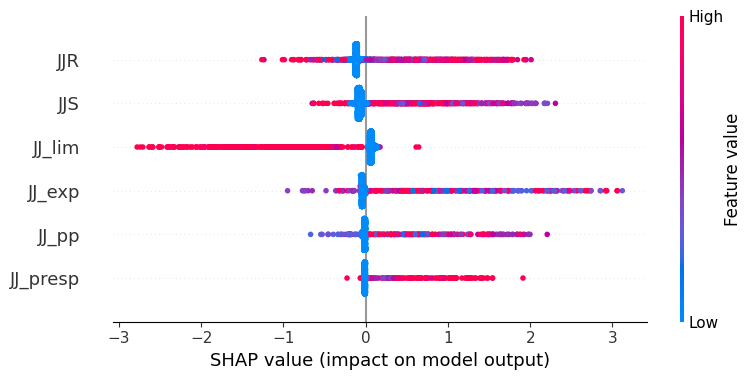

In [ ]:
shap.summary_plot(
    shap_vals,
    test_data,
    show=False,

)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

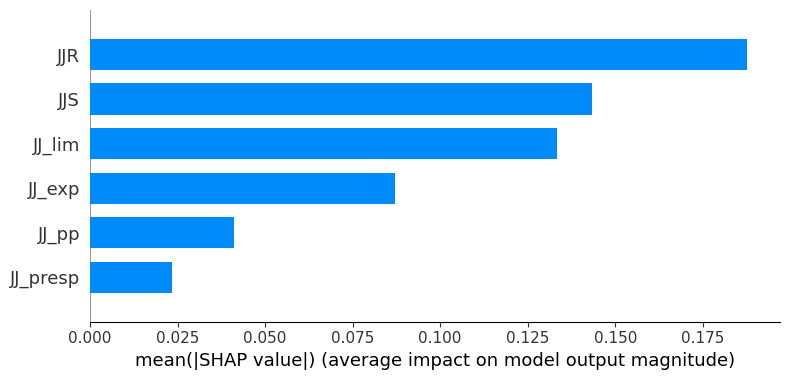

In [ ]:
shap.summary_plot(
    shap_vals,
    test_data,
    plot_type="bar",
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()
